In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from deep_KO_learning import Net

In [3]:
### Loading trained network ### 

script_dir = os.path.dirname('deep_KO_learning.py') # getting relative path
trained_models_path = os.path.join(script_dir, 'trained_models') # which relative path do you want to see
data_path = os.path.join(script_dir,'data/')

netsize_dir = trained_models_path + '/mt_poly_bt_netsize.pickle' # contains the shape of network
net_dir = trained_models_path+'/mt_poly_bt_net.pt' # contains params of network

NUM_INPUTS,NUM_OUTPUTS,HL_SIZES = pickle.load(open(netsize_dir,'rb'))

model = Net(NUM_INPUTS,NUM_OUTPUTS,HL_SIZES)
model.load_state_dict(torch.load(net_dir))
model.eval();

In [4]:
### Loading corresponding dataset ###

file_dir = 'mt_poly_bt_TPMs.p' # dataset

def get_snapshot_matrices(X,nT,nTraj): 
    '''This function assumes the global snapshot matrix is constructed with trajectories 
        sequentially placed in the columns'''
    prevInds = [x for x in range(0,nT-1)]
    forInds = [x for x in range(1,nT)]
    for i in range(0,nTraj-1):
        if i == 0:
            more_prevInds = [x + nT for x in prevInds]
            more_forInds = [x + nT for x in forInds]
        else: 
            more_prevInds = [x + nT for x in more_prevInds]
            more_forInds = [x + nT for x in more_forInds]
        prevInds = prevInds + more_prevInds
        forInds = forInds + more_forInds
    Xp = X[:,prevInds]
    Xf = X[:,forInds]
    return Xp,Xf

X,nT,nTraj = pickle.load(open(data_path+file_dir,'rb'))
Xp,Xf = get_snapshot_matrices(X,nT,nTraj)
trainXp = torch.Tensor(Xp.T)
trainXf = torch.Tensor(Xf.T)
testX = torch.Tensor(X.T)

numDatapoints = nT*nTraj # number of total snapshots

print('Dimension of the state: ' + str(trainXp.shape[1]));
print('Number of trajectories: ' + str(nTraj));
print('Number of total snapshots: ' + str(nT*nTraj));

Dimension of the state: 1206
Number of trajectories: 8
Number of total snapshots: 32


In [5]:
K = model.linears[-1].weight[:].detach().numpy()
PsiX_test = (model(testX)['PsiXf']).detach().numpy().T

Trajectory 6, MSE: 0.00288


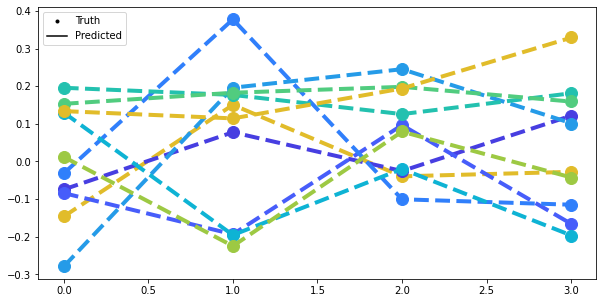

In [6]:
import matplotlib.lines as mlines

numStates = NUM_INPUTS
traj = np.random.randint(0,nTraj) # np.random.randint(0,nTraj/2)
init_index = traj*(nT)

predHorizon = nT
PsiX_pred = np.zeros((K.shape[0],predHorizon))
for i in range(0,predHorizon):
    PsiX_pred[:,i:i+1] = np.dot(np.linalg.matrix_power(K,i),PsiX_test[:,init_index:init_index+1]) 

mse = np.linalg.norm(PsiX_test[:,init_index:init_index+predHorizon] - PsiX_pred,'fro')/np.linalg.norm(PsiX_test[:,init_index:init_index+predHorizon],'fro')
print('Trajectory ' + str(traj) + ', MSE: ' + str(round(mse,5)))

import pandas as pd
parula_cmap = pd.read_csv('parula_cmap.csv').to_numpy()
pcmap = parula_cmap[0:200,:]

truthLeg = mlines.Line2D([], [], color='black',linestyle='',marker='.',label='Truth')
predLeg = mlines.Line2D([], [], color='black',linestyle='-',label='Predicted')
numCurves = 10 # how many gene preds do you want to plot?
cmap_inds = np.round(np.linspace(0,pcmap.shape[0],numCurves)) - 1
plotStates = np.random.randint(1,numStates-1,numCurves)
plt.figure(figsize=(10,5));
for i in range(0,len(plotStates)):
    plt.plot(PsiX_test[plotStates[i],init_index:init_index+predHorizon],'o',ms=12,lw=3,color=pcmap[int(cmap_inds[i]),:]);
    plt.plot(PsiX_pred[plotStates[i],0:predHorizon],'--',ms=10,lw=4,color=pcmap[int(cmap_inds[i]),:]);
    plt.legend(handles=[truthLeg,predLeg]);
#     plt.ylabel(r'$\mathbf{x}$'+r'_{'+str(i)+r'}')


In [7]:
### A better prediction calculation ###

PsiX_pred = np.zeros((K.shape[0],numDatapoints))
trajInds = [x for x in range(0,nT)]
trajInds = [trajInds for x in range(0,nTraj)]
trajInds = [j for i in trajInds for j in i] 
count = 0
initInd = 0
for i in range(0,nTraj):
    psix_test_ic = PsiX_test[:,i*nT:i*nT+1]
    for j in range(0,nT):
        PsiX_pred[:,count:count+1] = np.dot(np.linalg.matrix_power(K,j),psix_test_ic) 
        count += 1

In [8]:
### storing the mean squared errors for each gene (row) ###
per_gene_mse = []
for k in range(1,NUM_INPUTS+1):
    den = np.linalg.norm(PsiX_test[k,:],ord=2)
    if den == 0.0:
        den = 1
    dist = np.linalg.norm(PsiX_pred[k,:] - PsiX_test[k,:],ord=2)/den
    if np.isinf(dist):
        dist = 0
    per_gene_mse.append(dist)


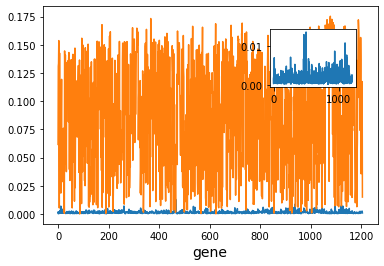

In [19]:
total_mu = np.mean(X,axis=1)

fig, ax1 = plt.subplots();
left, bottom, width, height = [0.65, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height]);
ax1.plot(per_gene_mse);
ax1.plot(np.abs(total_mu));
ax2.plot(per_gene_mse);
# ax2.plot(np.abs(total_mu));
# ax2.set_xlim([80,120]);
# ax2.set_ylim([0.00005,0.0006])
plt.savefig()

<Figure size 432x288 with 0 Axes>

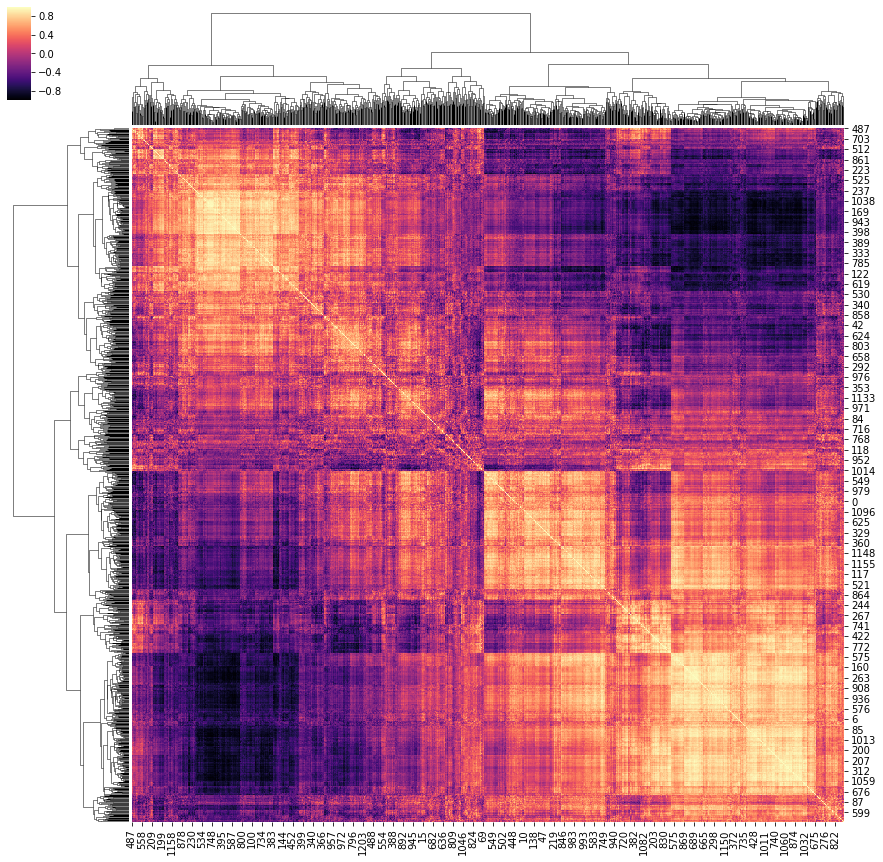

In [25]:
corr = np.dot(PsiX_pred,PsiX_test.T)
# for i in range(0,testX.shape[1]): 
#     if corr[i,i] == 0.0:
#         corr[i,i] = 1

# plt.figure(figsize=(15,7));
# ax = sn.heatmap(corr[1:testX.shape[1]+1,1:testX.shape[1]+1],cmap='magma');
# ax = sn.heatmap(corr[100:200,100:200],cmap='magma');
plt.figure();
sn.clustermap(corr[1:testX.shape[1]+1,1:testX.shape[1]+1],cmap='magma',figsize=(15,15));
# plt.savefig('correlation_pred_actual.pdf')


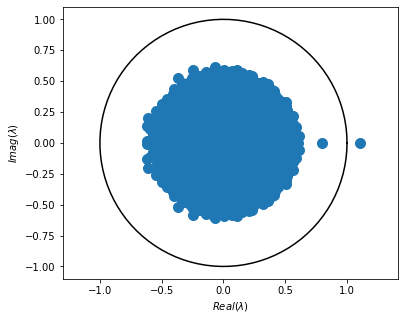

In [81]:
theta = np.linspace(0,2*math.pi,100)
plt.figure(figsize=(6,5));
plt.plot(np.real(np.linalg.eigvals(K)),np.imag(np.linalg.eigvals(K)),'o',ms=10);
plt.plot(np.cos(theta),np.sin(theta),color='black');
plt.ylabel('$Imag(\lambda)$');
plt.xlabel('$Real(\lambda)$');
plt.axis('equal');

In [11]:
def calc_SamplingMat(K,nOutputs):
    nObs = K.shape[0]
    evals, evecs = np.linalg.eig(K)
    SamplingMat = np.dot(np.concatenate((np.identity(nOutputs),np.zeros((nOutputs,nObs-nOutputs))),axis=1),np.linalg.inv(evecs))
    return SamplingMat

nOutputs = int(X.shape[0]/5) 
Wh = calc_SamplingMat(K,nOutputs)

In [12]:
### Sensitivity analysis ###

def calc_SensitivityMat(Wh,net,X_global,nGridpts,nOutputs):
    ''' Output sensitivity matrix is calculated by perturbing a single element of the state at a 
        time, computing the resulting outputs, subtracting the mean output from the resulting outputs,
        and finally averaging over the mean subtracted resultant outputs. 
    '''
    X_mean = np.mean(X_global,axis=1).reshape(X_global.shape[0],1) # the reference values
    PsiX_mean = (net(torch.Tensor(X_mean.T))['PsiXf']).detach().numpy().T 
    X_std = np.std(X,axis=1).reshape(X.shape[0],1)
    
    y_mean = np.dot(Wh,PsiX_mean)
    
    X_range = np.zeros((len(X_mean),nGridpts))
    for i in range(0,len(X_mean)):
        X_range[i,:] = np.linspace(X_mean[i]-X_std[i],X_mean[i]+X_std[i],nGridpts).T
        
    from copy import deepcopy
    S = np.zeros((nOutputs,X_global.shape[0]),dtype=complex) # sensitivity matrix 
    for s in range(0,S.shape[1]):
        X_sens = deepcopy(X_mean)
        Y = np.zeros((nOutputs,nGridpts),dtype=complex)
        for i in range(0,nGridpts): # looping through the various perturbations of state s
            X_sens[s,:] = X_range[s,i]
            PsiX_sens = (net(torch.Tensor(X_sens.T))['PsiXf']).detach().numpy().T    
            Y_sens = np.dot(Wh,PsiX_sens)
            Y[:,i:i+1] = Y_sens - y_mean # Take away y(x_mean) from every column of Y_sens
        S[:,s] = np.mean(Y,axis=1)

    # normalizing S to be between 0 and 1. 
    S = S/np.max(S)
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            S[i,j] = np.linalg.norm(S[i,j])
            
    return S.real

nGridpts = 100
S = calc_SensitivityMat(Wh,model,X,nGridpts,nOutputs)


<Figure size 432x288 with 0 Axes>

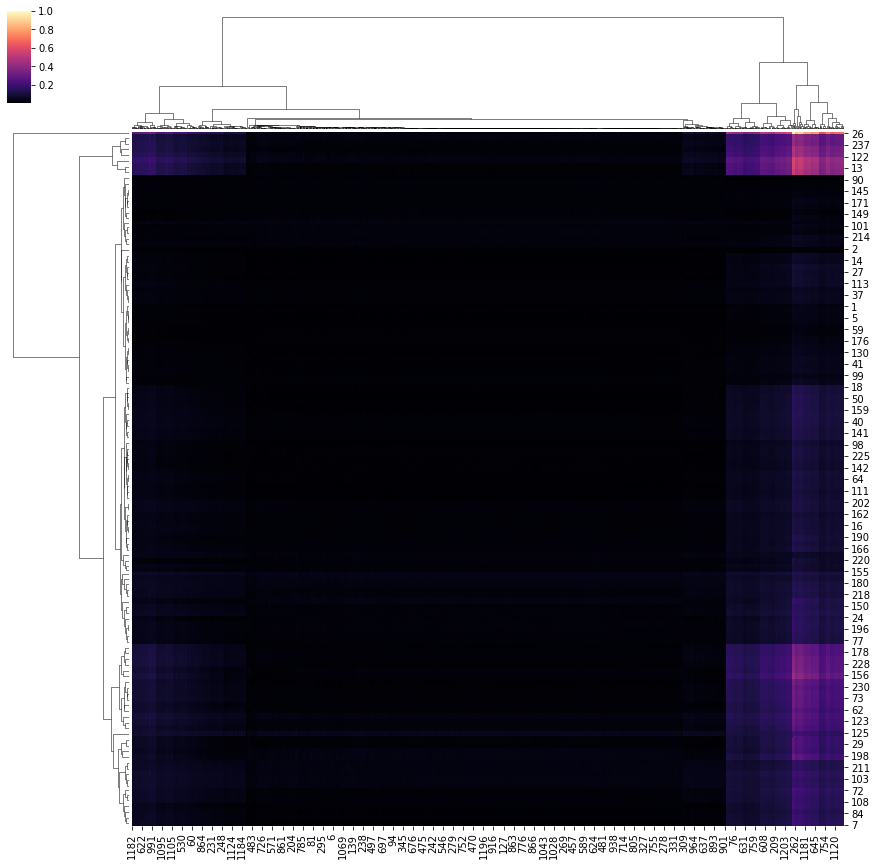

In [13]:
# plt.figure(figsize=(15,7));
# ax = sn.heatmap(S,cmap='magma');
plt.figure();
clustergrid = sn.clustermap(S,cmap='magma',figsize=(15,15));
# plt.savefig('bt_Wh_clustermap.pdf')

In [14]:
### Which genes impact the output the most? ###

names_dir = 'mt_poly_bt_geneNames.p'
gene_names = list(pickle.load(open(data_path+names_dir,'rb')))

perm_col_inds = clustergrid.dendrogram_col.reordered_ind # permuted column indices
sensGenes = [gene_names[i] for i in perm_col_inds[0:10]] # 10 of them 
sensInds = []
for i in range(len(sensGenes)):
    sensInds.append(gene_names.index(sensGenes[i]))
print(sensGenes)
print(sensInds)

['site-specific recombinase, phage integrase family CDS', 'D-methionine ABC transporter, ATP-binding protein CDS', 'nadA CDS', 'conserved hypothetical protein TIGR00103 CDS', 'greB CDS', 'gshA-1 CDS', 'rpiA CDS', 'putative DNA mismatch repair protein CDS', 'preprotein translocase, YajC subunit CDS', 'conserved hypothetical protein CDS']
[1155, 541, 212, 749, 515, 15, 823, 933, 415, 16]


In [ ]:
### magic six ### 
'''This is only for Pseudomonas fluorescens'''

md = 'malate dehydrogenase CDS'
akd = 'alpha-ketoacid dehydrogenase subunit beta CDS'
eat = 'ethanolamine ammonia-lyase subunit EutB CDS'
ivcd = 'isovaleryl-CoA dehydrogenase CDS'
# topa = 'topA CDS' filtered out for whatever reason (using the data where lanes and reads are treated seperately)
clpx = 'clpX CDS' 

print(gene_names.index(md),gene_names.index(akd),gene_names.index(eat),gene_names.index(ivcd),gene_names.index(clpx))